In [43]:
import os 
from sklearn.preprocessing import StandardScaler, RobustScaler
import pandas as pd
from datetime import datetime
import itertools
from sklearn.cluster import MiniBatchKMeans
from scipy.signal import detrend
from arch import arch_model
import numpy as np

DIR = os.path.join(os.path.dirname(os.getcwd()), "img")
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), "data")
DPI = 300
OBS_THRESH = 240
AS_OF_DATE = datetime(2024, 12, 31)
MCAP_THRESH = 300000

signals = ['b2m', 'c2p', 's2p', 'e2p', 'mom_12_1', 'mom_6_1', 'resid_mom']  # , 'strev'
signal_grouping = {
    "Value": ['b2m', 'c2p', 's2p', 'e2p'],
    "Momentum/Reversion": ['mom_12_1', 'mom_6_1', 'resid_mom', 'strev'],
}

In [2]:
raw_signals = pd.read_pickle(f"{DATA_DIR}/raw_signals.pkl")
crsp = pd.read_pickle(f"{DATA_DIR}/crsp.pkl")

## I should create a table with the wave length of each signal

In [3]:
# Sample stocks
active_flags = crsp.xs(AS_OF_DATE).all(axis=1)  # Filter 1: active stocks
mcap = crsp['shrout'].mul(crsp['prc'].abs()).xs(AS_OF_DATE, level='date')
mcap_flags = (mcap >= MCAP_THRESH).reindex(mcap.index).fillna(False)  # Filter 2: remove micro-caps
length_flags = (raw_signals.groupby("permno").count() > OBS_THRESH).all(axis=1)  # Filter 3: enough observations
sample_flags = pd.concat([active_flags, mcap_flags, length_flags], axis=1).all(axis=1)  # Put together the flags
sample_ids = sample_flags[sample_flags].index
print(len(sample_ids))

1752


In [4]:
for sec_ids, sgnl in itertools.product(sample_ids, signals):
    pass

In [44]:
x_t = raw_signals.xs(sec_ids, level='permno')[sgnl].dropna()

# LNA
z_t = pd.Series(detrend(x_t), index=x_t.index)

In [45]:
mdl = arch_model(z_t, p=1, o=0, q=1, mean="ARX", lags=1)
res = mdl.fit(disp="off")
z_t = np.divide(z_t, res.conditional_volatility)

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03001. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [46]:
scaler = StandardScaler().fit(z_t.reshape(-1, 1))
z_t = scaler.transform(z_t.reshape(-1, 1)).flatten()

AttributeError: 'Series' object has no attribute 'reshape'

<Axes: >

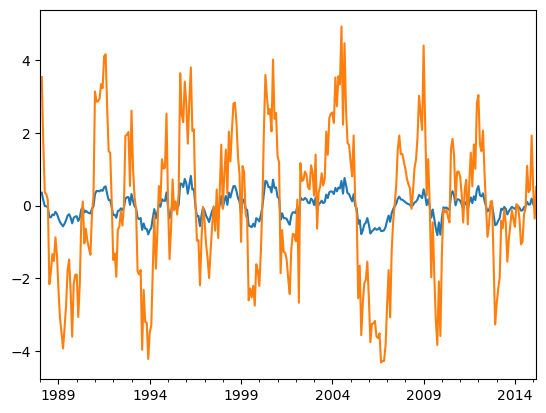

In [47]:
raw_signals.xs(sec_ids, level='permno')[sgnl].dropna().plot()
# x_t.plot()
pd.Series(z_t, index=x_t.index).plot()

<Axes: >

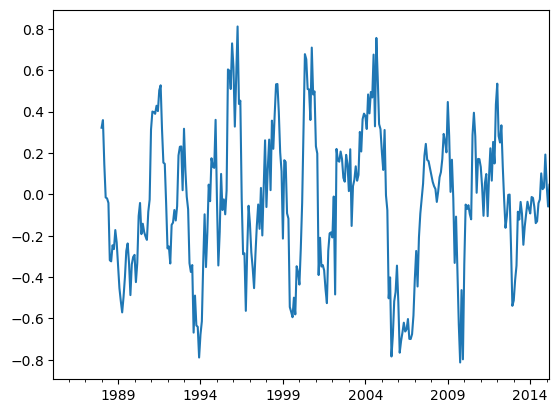

In [ ]:
x_t.plot()

n = len(x)
fhat = fft.rfft(x.values, n)
f, Pxx_den = signal.periodogram(x, 10e3, scaling='density')

# Clustering the frequency domain representation
# cat = MiniBatchKMeans(n_clusters=2, n_init="auto", init="k-means++", random_state=1234).fit(Pxx_den.reshape(-1, 1))
# filt_val = cat.cluster_centers_.flatten().argmax()
# filt_flags = cat.labels_ == filt_val

In [3]:
S = raw_signals["mom_12_1"].unstack()
last_valid_obs = S.iloc[-1].notnull()
enough_obs = S.count() > OBS_THRESH
is_valid = enough_obs & last_valid_obs  # Time series to be used to estimate the parameters
S = S.loc[:, is_valid]  # Filtered subset

In [4]:
len(is_valid)

26141

<Axes: >

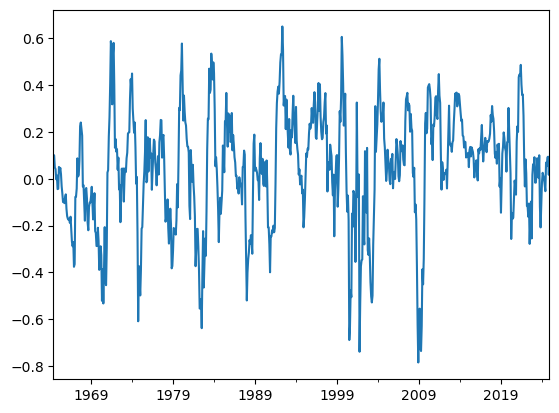

In [4]:
_id = 10145
s = S[_id].dropna()
s.plot()

In [5]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(s.to_frame())

In [6]:
# LNA
s_a = transformer.transform(s.values.reshape(-1, 1)).flatten()

<Axes: >

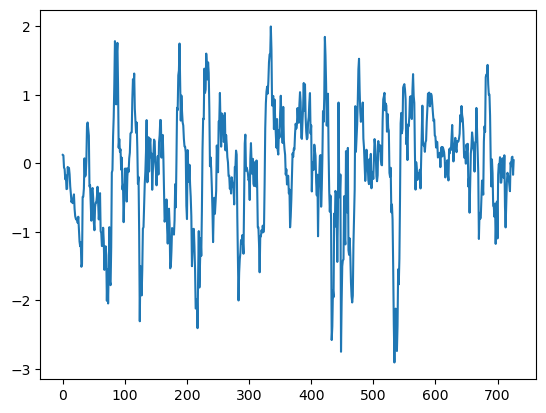

In [7]:
pd.Series(s_a).plot()